# Project 4 - Data Science Salaries - Web Scraping & Logistic Regression

In this project, we will collect data by scraping Indeed.com and then build a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. Being to able extrapolate or predict the expected salaries from other listings could be useful for job posting sites.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression. While more precision may be better, there is a fair amount of natural variance in job salaries therefore predicting a range be may be useful.

## 1. Scraping job listings from Indeed.com

In [1]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

In [2]:
import requests
import bs4
from bs4 import BeautifulSoup

In [3]:
result_test = requests.get(URL)
soup = BeautifulSoup(result_test.text)
print soup.prettify()

<!DOCTYPE html>
<html lang="en">
 <head>
  <meta content="text/html;charset=utf-8" http-equiv="content-type"/>
  <!-- pll -->
  <script src="/s/2c2181b/en_US.js" type="text/javascript">
  </script>
  <link href="/s/1a7c741/jobsearch_all.css" rel="stylesheet" type="text/css"/>
  <link href="http://rss.indeed.com/rss?q=data+scientist+%2420%2C000&amp;l=New+York" rel="alternate" title="Data Scientist $20,000 Jobs, Employment in New York, NY" type="application/rss+xml"/>
  <link href="/m/jobs?q=data+scientist+%2420%2C000&amp;l=New+York" media="handheld" rel="alternate"/>
  <script type="text/javascript">
   window['closureReadyCallbacks'] = [];

    function call_when_jsall_loaded(cb) {
        if (window['closureReady']) {
            cb();
        } else {
            window['closureReadyCallbacks'].push(cb);
        }
    }
  </script>
  <script src="/s/3f52f7f/jobsearch-all-compiled.js" type="text/javascript">
  </script>
  <script type="text/javascript">
   var pingUrlsForGA = [];

var

/Users/chloe/anaconda/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file /Users/chloe/anaconda/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


### a. Write unctions to extract location, company, job, and salary

In [4]:
# Define functions
def extract_title(result):
    try:
        title = result.find_all('a',  class_="turnstileLink", attrs={'data-tn-element' : True})[0].get_text()
        
    except Exception:
        title = 'No title specified'
    
    return title


def extract_location(result):
    try:
        location = result.find_all('span',  class_="location")[0].get_text()

    except Exception:
        location = 'No location specified'
    
    return location


def extract_company(result):
    try:
        company = result.find_all('span',  class_="company")[0].get_text().strip('\n').strip(' ')

    except Exception:
        company = 'No company specified'
    
    return company

def extract_salary(result):
    try:
        salary = result.find('nobr').get_text()
        #adding .find_all('td',  class_="snip") before find_all(nobr) does not return anything
    except Exception:
        salary = 'No salary specified'
    
    return salary


# Get job entries from soup
results = soup.find_all('div', class_=' row result')


# Test functions on first job entry
print 'Job title:', extract_title(results[0])
print 'Company:', extract_company(results[0])
print 'Location:', extract_location(results[0])
print 'Salary:', extract_salary(results[0])

Job title: Analytics
Company: Foursquare
Location: New York, NY
Salary: No salary specified


### b. Collect results from multiple cities

In [6]:
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 1010

results = []

for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
    'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
    'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', 'New+Orleans']):
    for start in range(0, max_results_per_city, 10):
        URL = url_template.format(city, start)
        result = requests.get(URL)
        results.append(BeautifulSoup(result.text))

We only included a max results per city of 1000 as Indeed seems to only allow up to 1000 results per city. All URLs getting results from 1010 and above give the same results as the URL getting results from 1000.

In [7]:
print results[0].prettify()

<!DOCTYPE html>
<html lang="en">
 <head>
  <meta content="text/html;charset=utf-8" http-equiv="content-type"/>
  <!-- pll -->
  <script src="/s/2c2181b/en_US.js" type="text/javascript">
  </script>
  <link href="/s/1a7c741/jobsearch_all.css" rel="stylesheet" type="text/css"/>
  <link href="http://rss.indeed.com/rss?q=data+scientist+%2420%2C000&amp;l=Houston" rel="alternate" title="Data Scientist $20,000 Jobs, Employment in Houston, TX" type="application/rss+xml"/>
  <link href="/m/jobs?q=data+scientist+%2420%2C000&amp;l=Houston" media="handheld" rel="alternate"/>
  <script type="text/javascript">
   window['closureReadyCallbacks'] = [];

    function call_when_jsall_loaded(cb) {
        if (window['closureReady']) {
            cb();
        } else {
            window['closureReadyCallbacks'].push(cb);
        }
    }
  </script>
  <script src="/s/3f52f7f/jobsearch-all-compiled.js" type="text/javascript">
  </script>
  <script type="text/javascript">
   var pingUrlsForGA = [];

var se

### c. Parse out location, title, company and salary and create a dataframe

In [8]:
import pandas as pd

Jobs = []
Companies = []
Locations = []
Salaries = []

for i in range(len(results)):
    page_results = results[i].find_all('div', class_=' row result')
    for j in range(len(page_results)):
        Jobs.append(extract_title(page_results[j]))
        Companies.append(extract_company(page_results[j]))
        Locations.append(extract_location(page_results[j]))
        Salaries.append(extract_salary(page_results[j]))
                         
offers_df = pd.DataFrame({'Job': Jobs, 'Company': Companies, 'Location': Locations, 'Salary': Salaries})
offers_df.head()

,Company,Job,Location,Salary
0,UT Health Science Center at Houston,Statistician,"Houston, TX",No salary specified
1,SYSCO,Sr Data Scientist,"Houston, TX 77038",No salary specified
2,Houston Methodist,Scientist,"Houston, TX 77030 (Medical area)",No salary specified
3,Quantlab Financial,Quantitative Research Scientist - Options Stra...,"Houston, TX",No salary specified
4,Reed Elsevier,Psychometrician – Data Analyst,"Houston, TX",No salary specified


In [9]:
#Check how many rows include salaries
len(offers_df.loc[offers_df['Salary'] != 'No salary specified', 'Salary'])

1630

### d. Clean salary data - filter entries without salaries or salaries that are not yearly and remove duplicate entries

In [10]:
#Get dataframe dimensions
offers_df.shape

(12479, 4)

In [11]:
# Drop duplicate entries
offers_df.drop_duplicates(inplace = True)
offers_df.shape

(2622, 4)

Some cities like Houston only have a couple hundred results in total so results from 200 and above are actually duplicates which have now been deleted.

In [12]:
# Drop rows without salary entries
rows_without_salary = offers_df.loc[offers_df['Salary'] == 'No salary specified']
offers_df.drop(rows_without_salary.index, inplace = True)
offers_df.shape

(181, 4)

In [13]:
# Drop rows with monthly, weekly and hourly salaries
rows_with_hourly_salaries = offers_df.loc[offers_df['Salary'].str.contains('hour')]
rows_with_weekly_salaries = offers_df.loc[offers_df['Salary'].str.contains('week')]
rows_with_monthly_salaries = offers_df.loc[offers_df['Salary'].str.contains('month')]

offers_df.drop(rows_with_hourly_salaries.index, inplace = True)
offers_df.drop(rows_with_weekly_salaries.index, inplace = True)
offers_df.drop(rows_with_monthly_salaries.index, inplace = True)

offers_df.shape

(139, 4)

In [14]:
# Check that indeed_df contains only yearly salaries
offers_df.loc[offers_df['Salary'].str.contains('year') == False]

,Company,Job,Location,Salary


Our dataframe now contains only yearly salaries. It has 139 unique rows.

In [15]:
offers_df.head()

,Company,Job,Location,Salary
15,Baylor College of Medicine,Lead Bioinformatics Programmer,"Houston, TX","$83,000 - $102,000 a year"
506,"Maricopa County, AZ",Research Analyst,"Phoenix, AZ 85003 (Central City area)","$44,616 - $82,618 a year"
508,Arizona State University,Data Analysis Specialist,"Tempe, AZ","$47,476 - $60,000 a year"
509,Arizona State University,Management Research Analyst,"Tempe, AZ","$47,476 - $50,000 a year"
512,Arizona Health Care Cost Containment System,DATA ANALYSIS AND RESEARCH MANAGER,"Phoenix, AZ","$65,000 - $72,000 a year"


In [16]:
# Define convert_salary function that converts salary string into an int (single number or average of range)

def convert_salary(sal_string):
    salary = 0
    clean_sal = sal_string.replace(',', '')
    clean_sal = clean_sal.replace('$', '')
    sal_range = [int(s) for s in clean_sal.split() if s.isdigit()]
    if len(sal_range) > 1:
        salary = (sal_range[0] + sal_range[1]) / 2
    else:
        salary = sal_range[0]
    return salary
  

In [17]:
# Convert salary column to int

offers_df['Salary'] = offers_df['Salary'].apply(convert_salary)

In [18]:
offers_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 15 to 11869
Data columns (total 4 columns):
Company     139 non-null object
Job         139 non-null object
Location    139 non-null object
Salary      139 non-null int64
dtypes: int64(1), object(3)
memory usage: 5.4+ KB


In [19]:
# Clean'Location' coloumn and create separate columns for City and State

offers_df['City'] = [i.split(',')[0] for i in offers_df['Location']]

offers_df['State'] = [i.split(',')[1][1:4] for i in offers_df['Location']]

offers_df.head()

,Company,Job,Location,Salary,City,State
15,Baylor College of Medicine,Lead Bioinformatics Programmer,"Houston, TX",92500,Houston,TX
506,"Maricopa County, AZ",Research Analyst,"Phoenix, AZ 85003 (Central City area)",63617,Phoenix,AZ
508,Arizona State University,Data Analysis Specialist,"Tempe, AZ",53738,Tempe,AZ
509,Arizona State University,Management Research Analyst,"Tempe, AZ",48738,Tempe,AZ
512,Arizona Health Care Cost Containment System,DATA ANALYSIS AND RESEARCH MANAGER,"Phoenix, AZ",68500,Phoenix,AZ


In [65]:
# Remove extra spaces in state names
offers_df['State'] = [i.replace(' ', '') for i in offers_df['State']]

In [66]:
offers_df['State'].value_counts()

NY    37
CA    22
IL    13
FL    12
TX    12
GA    11
AZ     9
PA     9
CO     7
OR     3
WA     3
NJ     1
Name: State, dtype: int64

### e. Save results as a CSV

In [67]:
#Save to csv
offers_df.to_csv('Indeed_job_offers.csv', header=True, encoding='UTF-8', index=False)

## 2. Predicting salaries using Logistic Regression

### a. Load in the the data of scraped salaries

In [1]:
#Load csv file
import pandas as pd
import numpy as np

indeed_df = pd.read_csv('Indeed_job_offers.csv')

In [2]:
indeed_df.head()

,Company,Job,Location,Salary,City,State
0,Baylor College of Medicine,Lead Bioinformatics Programmer,"Houston, TX",92500,Houston,TX
1,"Maricopa County, AZ",Research Analyst,"Phoenix, AZ 85003 (Central City area)",63617,Phoenix,AZ
2,Arizona State University,Data Analysis Specialist,"Tempe, AZ",53738,Tempe,AZ
3,Arizona State University,Management Research Analyst,"Tempe, AZ",48738,Tempe,AZ
4,Arizona Health Care Cost Containment System,DATA ANALYSIS AND RESEARCH MANAGER,"Phoenix, AZ",68500,Phoenix,AZ


### b. Create a new binary variable that is true when the salary is high (above the median)

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries.

In [3]:
# Compute median salary
median_salary = np.median(indeed_df['Salary'])
median_salary

85399.0

In [4]:
# Create binary column HIGH/LOW for salaries
indeed_df['Salary_bin'] = [True if x>= median_salary else False for x in indeed_df['Salary']]
indeed_df['Salary_bin'].value_counts() #Salary_bin column is split in half, either side of the median

True     70
False    69
Name: Salary_bin, dtype: int64

### c. Create a Logistic Regression model to predict High/Low salary

In [6]:
import statsmodels.api as sm

In [7]:
#Add dummy variables for the cities
city_dummies = pd.get_dummies(indeed_df['City'])

#Add dummy variables for the states
state_dummies = pd.get_dummies(indeed_df['State'])

##### (i) Logistic regression to predict salary based on city

In [8]:
logreg = sm.Logit(indeed_df['Salary_bin'], city_dummies).fit()
print logreg.summary()

         Current function value: 0.409147
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:             Salary_bin   No. Observations:                  139
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                           40
Date:                Mon, 07 Nov 2016   Pseudo R-squ.:                  0.4097
Time:                        12:46:18   Log-Likelihood:                -56.871
converged:                      False   LL-Null:                       -96.344
                                        LLR p-value:                 0.0002346
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Atlanta             0.2231      0.671      0.333      0.739        -1.092     1.538
Aurora            -26.0982   3.29e+05  -7.94e-05  

/Users/chloe/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [10]:
logreg.mle_retvals

{'Hessian': array([[ -1.59872102e-02,  -0.00000000e+00,  -0.00000000e+00, ...,
          -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00],
        [ -0.00000000e+00,  -6.66368029e-14,  -0.00000000e+00, ...,
          -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00],
        [ -0.00000000e+00,  -0.00000000e+00,  -1.07913669e-02, ...,
          -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00],
        ..., 
        [ -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00, ...,
          -2.34838231e-11,  -0.00000000e+00,  -0.00000000e+00],
        [ -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00, ...,
          -0.00000000e+00,  -2.34838231e-11,  -0.00000000e+00],
        [ -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00, ...,
          -0.00000000e+00,  -0.00000000e+00,  -1.94228464e-18]]),
 'converged': False,
 'fopt': 0.40914733966481859,
 'iterations': 35,
 'score': array([ -1.59744320e-18,  -6.66368029e-14,   0.00000000e+00,
          0.00000000e+00,   2.34945380e-

This model seems to have insignificant predictors and failed to converge. We will try to use states instead of cities as predictors in our model.

##### (ii) Logistic regression to predict salary based on state

In [20]:
logreg_s = sm.Logit(indeed_df['Salary_bin'], state_dummies).fit(maxiter = 100)
print logreg_s.summary()

         Current function value: 0.587014
         Iterations: 100
                           Logit Regression Results                           
Dep. Variable:             Salary_bin   No. Observations:                  139
Model:                          Logit   Df Residuals:                      127
Method:                           MLE   Df Model:                           11
Date:                Mon, 07 Nov 2016   Pseudo R-squ.:                  0.1531
Time:                        13:22:20   Log-Likelihood:                -81.595
converged:                      False   LL-Null:                       -96.344
                                        LLR p-value:                  0.001899
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
AZ            -2.0794      1.061     -1.961      0.050        -4.158    -0.001
CA             1.2238      0.509      2.405      0.016         0

/Users/chloe/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


This model also failed to converge. However, some states seem to be significant predictors.

The location of jobs in Arizona, California and Florida seems to have a statistically significant impact on salaries. A job located in California implies a higher salary, while jobs located in Arizona and Florida imply a lower salary.

##### (iii) Create new variables to represent interesting features of a job title


In [23]:
# Define boolean column for job title containing 'Senior'
indeed_df['Senior'] = indeed_df['Job'].str.lower().str.contains('senior')
indeed_df['Senior'].value_counts()

False    126
True      13
Name: Senior, dtype: int64

In [24]:
# Define boolean column for job title containing 'Lead'
indeed_df['Lead'] = indeed_df['Job'].str.lower().str.contains('lead')
indeed_df.loc[indeed_df['Lead'], :]

,Company,Job,Location,Salary,City,State,Salary_bin,Senior,Lead
0,Baylor College of Medicine,Lead Bioinformatics Programmer,"Houston, TX",92500,Houston,TX,True,False,True
35,DEPT. OF HOMELESS SERVICES,Compliance Team Leader,"Manhattan, NY",90981,Manhattan,NY,True,False,True
46,POLICE DEPARTMENT,"Coordinator / Lead Scientist, Municipal Storm ...","New York, NY",90981,New York,NY,True,False,True
76,Real Staffing,Lead Statistical Programmer,"Fort Washington, PA",110000,Fort Washington,PA,True,False,True
105,University of Miami,Lead Research Analyst (Biostatistics),"Coral Gables, FL",93100,Coral Gables,FL,True,False,True
115,Centers for Disease Control and Prevention,Lead Statistician (Health),"Atlanta, GA",120002,Atlanta,GA,True,False,True
117,SearchAccountingJobs,Lead Quantitative Analyst,"Atlanta, GA",177500,Atlanta,GA,True,False,True
127,State of Washington,TMDL Lead (Environmental Specialist 4),"Bellevue, WA",55548,Bellevue,WA,False,False,True


In [25]:
# Define boolean column for job title containing 'Quantitative' (i.e. looking for data scientists in finance)
indeed_df['Quantitative'] = indeed_df['Job'].str.lower().str.contains('quantitative')
indeed_df['Quantitative'].value_counts()

False    126
True      13
Name: Quantitative, dtype: int64

In [26]:
# Define boolean column for company containing 'University'
indeed_df['University'] = indeed_df['Company'].str.lower().str.contains('university')
indeed_df['University'].value_counts()

False    116
True      23
Name: University, dtype: int64

In [29]:
#Get dummy variables for senior, lead, quant and uni columns
senior_dummy = pd.get_dummies(indeed_df['Senior'], prefix='Senior', drop_first=True)
lead_dummy = pd.get_dummies(indeed_df['Lead'], prefix='Lead', drop_first=True)
quant_dummy = pd.get_dummies(indeed_df['Quantitative'], prefix='Quant', drop_first=True)
uni_dummy = pd.get_dummies(indeed_df['University'], prefix='Uni', drop_first=True)

#Merge predictor dummies into one dataframe
X_state_title_comp = state_dummies.join(senior_dummy).join(lead_dummy).join(quant_dummy).join(uni_dummy)

#Fit logistic regression model
logreg_stc = sm.Logit(indeed_df['Salary_bin'], X_state_title_comp).fit(maxiter = 100)
print logreg_stc.summary()

         Current function value: 0.499952
         Iterations: 100
                           Logit Regression Results                           
Dep. Variable:             Salary_bin   No. Observations:                  139
Model:                          Logit   Df Residuals:                      123
Method:                           MLE   Df Model:                           15
Date:                Mon, 07 Nov 2016   Pseudo R-squ.:                  0.2787
Time:                        13:28:43   Log-Likelihood:                -69.493
converged:                      False   LL-Null:                       -96.344
                                        LLR p-value:                 2.947e-06
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
AZ             -2.9413      1.429     -2.059      0.040        -5.741    -0.141
CA              1.2358      0.524      2.356      0.018      

/Users/chloe/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


This model also failedto converge although adding these four predictors slightly improved the log likelihood. Titles containing 'Lead' and 'Quantitative' seem to have a statistically significant impact on salaries.  
  
We will now rebuild the model in scikit-learn to calculate more accurate error rates using cross-validation and include regularisation techniques.  
We will then use gridsearch to find the optimal parameters for the model with the above predictors.  

##### (iv) Use scikit-learn


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

logreg_l2 = LogisticRegression()
results_l2 = logreg_l2.fit(X_state_title_comp, indeed_df['Salary_bin'])

print 'Coefficients:', results_l2.coef_

salary_predictions = results_l2.predict(X_state_title_comp)
print 'Log-Likelihood:', -log_loss(salary_predictions, indeed_df['Salary_bin'])

Coefficients: [[-1.04310261  1.20442484  0.13372741 -0.83913939 -0.0470932   0.97461023
  -0.35182913 -0.02611912 -0.71629033 -0.10905067  0.32348199  0.23745171
   0.11531835  1.2483309   1.66998302 -0.61989306]]
Log-Likelihood: -8.94542116087


##### (v) Cross-validation

In [34]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

cv_pred = cross_val_predict(results_l2, X_state_title_comp, indeed_df['Salary_bin'], cv=5)

print 'Accuracy:', accuracy_score(indeed_df['Salary_bin'], cv_pred)
print 'Precision:', precision_score(indeed_df['Salary_bin'], cv_pred)
print 'Recall:', recall_score(indeed_df['Salary_bin'], cv_pred)
print 'AUC:', roc_auc_score(indeed_df['Salary_bin'], cv_pred)

Accuracy: 0.503597122302
Precision: 0.506329113924
Recall: 0.571428571429
AUC: 0.503105590062


This model has very poor scores. We will now check if some predictors can be dropped to improve the model using L1 regularisation.

##### (vi) Compare L1 and L2 regularization for this logistic regression model

In [87]:
#Model with l1 regularisation

logreg_l1 = LogisticRegression(penalty='l1')
results_l1 = logreg_l1.fit(X_state_title_comp, indeed_df['Salary_bin'])

print 'Coefficients:', results_l1.coef_

print 'Log-Likelihood:', -log_loss(salary_predictions_l1, indeed_df['Salary_bin'])

Coefficients: [[-1.16110565  1.27313742  0.         -0.88501396  0.          0.98214045
   0.          0.         -0.26751501  0.          0.05846413  0.          0.
   1.43961452  2.06525777 -0.5058446 ]]
Log-Likelihood: -9.19393032908


In [86]:
Coefficients_per_columns = zip(X_state_title_comp.columns, results_l1.coef_[0])
Coefficients_per_columns

[('AZ', -1.1611427933726659),
 ('CA', 1.2730997547003384),
 ('CO', 0.0),
 ('FL', -0.88505615469549459),
 ('GA', 0.0),
 ('IL', 0.98210371135930064),
 ('NJ', 0.0),
 ('NY', 0.0),
 ('OR', -0.26755534478774401),
 ('PA', 0.0),
 ('TX', 0.058425654526619096),
 ('WA', 0.0),
 ('Senior_True', 0.0),
 ('Lead_True', 1.439614322917637),
 ('Quant_True', 2.0652323405135173),
 ('Uni_True', -0.5058365267972833)]

In [88]:
results_l1.intercept_

array([-0.26701444])

In [79]:
#Calculate scores
cv_pred_l1 = cross_val_predict(results_l1, X_state_title_comp, indeed_df['Salary_bin'], cv=5)

print 'Accuracy:', accuracy_score(indeed_df['Salary_bin'], cv_pred_l1)
print 'Precision:', precision_score(indeed_df['Salary_bin'], cv_pred_l1)
print 'Recall:', recall_score(indeed_df['Salary_bin'], cv_pred_l1)

Y_score = logreg_l1.decision_function(X_state_title_comp)
print 'AUC:', roc_auc_score(indeed_df['Salary_bin'], Y_score)

Accuracy: 0.575539568345
Precision: 0.582089552239
Recall: 0.557142857143
AUC: 0.817494824017


The model improved with l1 regularisation as some coefficients have been cancelled out. CO, GA, NJ, NY, PA, WA, Senior in title are irrelevant predictors for salary. We can now predict (still with a low accuracy score) the salary category based on the job's location and title (if it contains Lead or Quantitative).

We will now use gridsearch to optimise the model parameters.

In [82]:
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(logreg_l1, {'penalty':['l1', 'l2'], 'C':[10e-4, 10e-3, 10e-2, 0.1, 1, 10, 100, 1000, 10e4]})
gs.fit(X_state_title_comp, indeed_df['Salary_bin'])

'''logreg_gs = LogisticRegressionCV(Cs=15, cv=5, penalty='l1', solver='liblinear')
results_gs = logreg_gs.fit(X_state_title_comp, indeed_df['Salary_bin'])
logreg_gs.C_'''
                  
gs.best_params_

{'C': 10, 'penalty': 'l1'}

Optimal parameters are C=10 and L1 regulation.  
Let's calculate this model.

In [83]:
#Log reg modal c=10 L1 regulation
logreg_l1_C10 = LogisticRegression(penalty='l1', C=10)
results_l1_C10 = logreg_l1_C10.fit(X_state_title_comp, indeed_df['Salary_bin'])

#Calculate scores
cv_pred_l1_C10 = cross_val_predict(results_l1_C10, X_state_title_comp, indeed_df['Salary_bin'], cv=5)

print 'Accuracy:', accuracy_score(indeed_df['Salary_bin'], cv_pred_l1_C10)
print 'Precision:', precision_score(indeed_df['Salary_bin'], cv_pred_l1_C10)
print 'Recall:', recall_score(indeed_df['Salary_bin'], cv_pred_l1_C10)

Y_score_C10 = logreg_l1_C10.decision_function(X_state_title_comp)
print 'AUC:', roc_auc_score(indeed_df['Salary_bin'], Y_score_C10)

Accuracy: 0.503597122302
Precision: 0.506493506494
Recall: 0.557142857143
AUC: 0.826397515528


This model's scores are actually worse than the previous one (C=1 and L1 regulation) so we will stick to our previous model.

Plot ROC curve of the model to get a visual representation of the model performance.

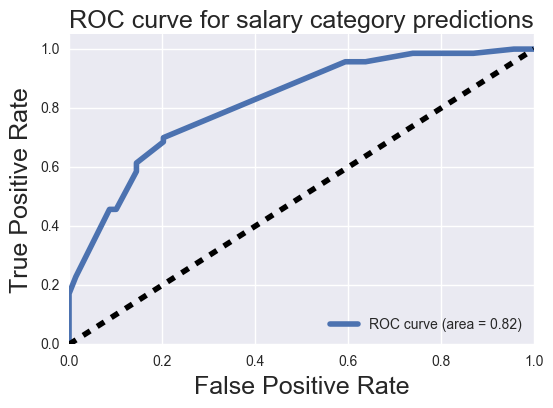

In [55]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

FPR, TPR, THR = roc_curve(indeed_df['Salary_bin'], Y_score)
ROC_AUC = auc(FPR, TPR)

plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve for salary category predictions', fontsize=18)
plt.legend(loc="lower right")
plt.show()

Our model seems to be able to predict salary categories better than guessing.    
Model equation: log(odds(salary_category)) = -0.27 - 1.16*AZ + 1.27*CA - 0.89*FL + 0.98*IL - 0.27*OR + 1.44*Lead + 2.07*Quantitative  

However it still has a low accuracy. We will now try using Count Vectorizer to see if other key words in the job title could help predict the salary category. 

In [75]:
# Find most common words in job title column
from sklearn.feature_extraction.text import CountVectorizer

cnt_vect = CountVectorizer(binary=True, stop_words='english', max_features=3)
X = cnt_vect.fit(indeed_df['Job'])
common_words = X.vocabulary_.keys()
print 'Most common words in job title:', common_words

Most common words in job title: [u'scientist', u'research', u'analyst']


In [84]:
from sklearn.linear_model import LogisticRegressionCV

#Improve model to include most common words in job title as predictors

indeed_df['Scientist'] = indeed_df['Job'].str.lower().str.contains('scientist')
scientist_dummy = pd.get_dummies(indeed_df['Scientist'], prefix='Scientist', drop_first=True)

indeed_df['Research'] = indeed_df['Job'].str.lower().str.contains('research')
research_dummy = pd.get_dummies(indeed_df['Research'], prefix='Research', drop_first=True)

indeed_df['Analyst'] = indeed_df['Job'].str.lower().str.contains('analyst')
analyst_dummy = pd.get_dummies(indeed_df['Analyst'], prefix='Analyst', drop_first=True)

#Merge predictor dummies into one dataframe
X_state_title = state_dummies.join(lead_dummy).join(quant_dummy).join(research_dummy).join(scientist_dummy).join(analyst_dummy)


#Build model with optimal C
logreg_all = LogisticRegressionCV(Cs=15, cv=5, penalty='l1', solver='liblinear')
results_all = logreg_all.fit(X_state_title, indeed_df['Salary_bin'])

#Calculate scores
cv_pred_all = cross_val_predict(results_all, X_state_title, indeed_df['Salary_bin'], cv=5)

print 'Accuracy:', accuracy_score(indeed_df['Salary_bin'], cv_pred_all)
print 'Precision:', precision_score(indeed_df['Salary_bin'], cv_pred_all)
print 'Recall:', recall_score(indeed_df['Salary_bin'], cv_pred_all)

Y_score_all = logreg_all.decision_function(X_state_title)
print 'AUC:', roc_auc_score(indeed_df['Salary_bin'], Y_score_all)

Accuracy: 0.546762589928
Precision: 0.55223880597
Recall: 0.528571428571
AUC: 0.853519668737


These three new predictors have slightly improved the ROC score but decreased the accuracy so we will keep logreg_l1 as our model. 

## 3. Report 

### Summary
The aim of this report was to investigate the influence of several parameters on the salary of Data Scientists in the US. After studying job offers from Indeed.com we concluded that job location and some key characteristics of the job title were key influencers in predicting whether a salary would be considered as high or low. In particular, jobs located in California tend to have higher salaries. Similarly jobs including 'Lead' or 'Quantitative' in their titles have higher salaries.  
  
### Introduction
There has been a massive increase in the demand for data scientists over the past ten years and as a new company it is in our best interest to evaluate salary offers across the US in order to offer realistic expectations to both our clients and to candidates.  
  
### Methods
We extracted 2,622 job offers from Indeed.com across 16 locations in the US. Out of these, we selected the 139 offers that included yearly salaries. Based on these 139 entries we built a model to try and assess which parameters influenced job salaries.   
Salaries were divided in two categories: **LOW** (less than $85,400 - which matched the median salary of our dataset) and **HIGH** (over $85,400).  
We studied the influence of job location, company type and job title key words on salary category.

### Results
According to our results,the probability for a job to be associated with a salary considered as high, is influenced by its location as well as its title. 
Indeed, Lead Data Scientist and Quantitative Data Scientists have a much higher probability of getting a high salary than other job titles. Similarly jobs located in California are more likely to be associated with a high salary. On the opposite, jobs located in Arizona tend to be associated with lower salaries.  